In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://aifactory.space/competition/detail/2226

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/'

/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원


In [ ]:
!ls

abod.pickle		m_1.pickle  m_5.pickle	       s_1.pickle  test.ipynb
autoencoder.h5		m_2.h5	    m_e.h5	       s_2.pickle  train.ipynb
IsolationForest.pickle	m_2.pickle  m_e.pickle	       s_5.pickle
m_1.h5			m_5.h5	    rectified_adam.py  s_e.pickle


# Train

## Import

In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import *

from pyod.models.abod import ABOD
from pyod.models.deep_svdd import DeepSVDD
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Input, Dense, BatchNormalization, Dropout, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

import pickle
import numpy as np
import matplotlib.pyplot as plt

## Data Load

In [4]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/train_data.csv')

In [5]:
def tyep_to_hp(type_no):
  if type_no == 1:
    return 20
  elif type_no == 2:
    return 10
  elif type_no == 3:
    return 50
  else:
    return 30


df_data = df_data.drop(axis=1, columns=['out_pressure'])
#df_data['hp'] = df_data['type'].apply(tyep_to_hp)


In [7]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,15.64,1280.0,54.22,2.71,7


In [ ]:
df_data = df_data[(df_data['motor_vibe'] < 5) & (df_data['air_inflow'] < 3.5) & (df_data['motor_current'] < 45) & (df_data['air_end_temp'] > 35) & (df_data['motor_temp'] > 53) ]

In [ ]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,30
1,2.97,59.28,38.40,3142.0,74.91,3.75,30
2,1.91,45.29,24.73,2023.0,62.48,3.12,30
3,2.37,51.33,30.63,2506.0,67.84,3.39,30
4,1.90,45.21,24.65,2017.0,62.41,3.12,30
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,30
2459,2.04,46.94,26.34,2155.0,63.94,3.20,30
2460,1.19,35.74,15.39,1259.0,53.99,2.70,30
2461,1.21,36.00,15.64,1280.0,54.22,2.71,30


## AutoEncoder

In [ ]:
clear_session()

def AE(n_inputs):
  #n_inputs = df_data.shape[1]

  # configure
  input_data = Input(shape=(n_inputs,))

  # layers
  encoded = Dense(n_inputs//2, activation='relu')(input_data)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)
  encoded = Dense(n_inputs//4, activation='relu')(dropout)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)

  n_bottneck = 200
  bottneck = Dense(n_bottneck, activation='relu')(dropout)

  decoded = Dense(n_inputs//4, activation='relu')(bottneck)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs//2, activation='relu')(dropout)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs, activation='relu')(dropout)

  # Models
  autoencoder = Model(input_data, decoded) # autoencoder

  encoder = Model(input_data, encoded) # encoder
  return autoencoder

In [ ]:
clear_session()

n_inputs = df_data.shape[1]

# configure
input_data = Input(shape=(n_inputs,))

# layers
encoded = Dense(n_inputs//2, activation='relu')(input_data)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)
encoded = Dense(n_inputs//4, activation='relu')(dropout)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)

n_bottneck = 200
bottneck = Dense(n_bottneck, activation='relu')(dropout)

decoded = Dense(n_inputs//4, activation='relu')(bottneck)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs//2, activation='relu')(dropout)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs, activation='relu')(dropout)

# Models
autoencoder = Model(input_data, decoded) # autoencoder

encoder = Model(input_data, encoded) # encoder

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
es = EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True, verbose=1)

In [ ]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(df_data)

In [ ]:
x_train, x_val, _, _ = train_test_split(train_df,train_df,random_state=2023,test_size=0.3)

autoencoder.fit(x_train, x_train, epochs = 100, callbacks = [es], validation_split = 0.3)

Epoch 1/100
34/34 [==============================] - 3s 13ms/step - loss: 0.3144 - val_loss: 0.3070
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2584 - val_loss: 0.2951
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2476 - val_loss: 0.2762
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2251 - val_loss: 0.2506
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2047 - val_loss: 0.2253
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.1836 - val_loss: 0.2060
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1695 - val_loss: 0.1908
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1583 - val_loss: 0.1789
Epoch 9/100
34/34 [==============================] - 0s 6ms/step - loss: 0.1487 - val_loss: 0.1703
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1445 - val_loss: 0.1635
Epoch 11

In [ ]:
reconstructions = autoencoder.predict(x_val)
train_loss = tf.keras.losses.mae(reconstructions, x_val)

21/21 [==============================] - 0s 2ms/step


In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.3233443026341315


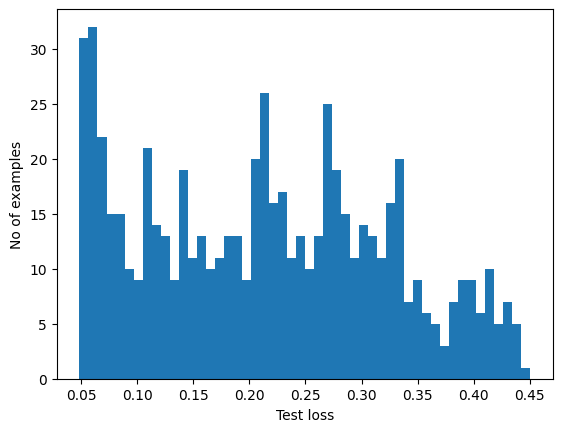

In [ ]:
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  pred = tf.math.less(loss, threshold)
  pred = np.where(pred,0,1)
  return pred

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))



In [ ]:
preds = predict(autoencoder, x_val, threshold)
print_stats(preds, np.array([0]*x_val.shape[0]))

Accuracy = 0.810477657935285


In [ ]:
autoencoder.fit(train_df, train_df, epochs = 100, callbacks = [es], validation_split = 0.3)

Epoch 1/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0729 - val_loss: 0.0634
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0722 - val_loss: 0.0645
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0724 - val_loss: 0.0652
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0721 - val_loss: 0.0663
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.0651
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0714 - val_loss: 0.0651
Epoch 6: early stopping


In [ ]:
autoencoder.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/autoencoder.h5')

## 모델 4개

In [ ]:
type_list = []
type_tmp_2 = []
type_tmp_1 = []
type_tmp_5 = []
type_tmp_e = []


for i,row in df_data.iterrows():
  #print(row)
  
  if row['type'] == 20:
    type_tmp_2.append(row)
  elif row['type'] == 10:
    type_tmp_1.append(row)
  elif row['type'] == 50:
    type_tmp_5.append(row)
  else:
    type_tmp_e.append(row)

type_list.append(type_tmp_2)
type_list.append(type_tmp_1)
type_list.append(type_tmp_5)
type_list.append(type_tmp_e)

In [ ]:
df_list = []

for ls in type_list:
  df = pd.DataFrame(ls).drop(axis=1,columns=['type'])
  df_list.append(df)
  print(df.shape)

(369, 6)
(366, 6)
(306, 6)
(1422, 6)


In [ ]:
models = []
scalers = []
#clear_session()

for i in range(4):
  print('='*30)
  print(i)

  df = df_list[i]
  model_tmp = ABOD()
  #model_tmp = DeepSVDD(preprocessing=False, 
                       use_ae=True,hidden_neurons=[df.shape[1],df.shape[1]//2, df.shape[1]//4],
                       random_state=2023, 
                       validation_size=0.2,
                       dropout_rate=0.8,
                       epochs = 50,)
  #model_tmp = model(df.shape[1])
  #model_tmp.compile(optimizer='adam', loss='mse')

  #es = EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True, verbose=1, )

  #scaler = MinMaxScaler()
  #scarer_df = scaler.fit_transform(df)
  #scalers.append(scaler)

  model_tmp.fit(df)
  #model_tmp.fit(scarer_df)
  #model_tmp.fit(scarer_df, scarer_df, epochs = 100, callbacks = [es], validation_split = 0.3)

  models.append(model_tmp)


0
12/12 [==============================] - 0s 2ms/step
Model: "model_111"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 dense_332 (Dense)              (None, 6)            36          ['input_75[0][0]']               
                                                                                                  
 dense_333 (Dense)              (None, 3)            18          ['dense_332[0][0]']              
                                                                                                  
 dropout_184 (Dropout)          (None, 3)            0           ['dense_333[0][0]']              
                                   

In [ ]:
string_list = ['2','1','5','e']

for i,m in enumerate(models): 
  #m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_' + string_list[i] + '.h5')
  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_' + string_list[i] + '.pickle', 'wb') as f:
    pickle.dump(m, f)
  #m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_' + string_list[i] + '.h5')
  
  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/s_' + string_list[i] + '.pickle', 'wb') as f:
    pickle.dump(scalers[i], f)


## 모델 8개

In [8]:
type_list = [[] for _ in range(8)]

for i,row in df_data.iterrows():
  type_list[int(row['type'])].append(row)

df_list = []
df_val_list = []

for ls in type_list:
  df = pd.DataFrame(ls).drop(axis=1,columns=['type'])
  df_list.append(df)
  #df_val_list.append(pd.DataFrame(ls[-30:]).drop(axis=1,columns=['type']))
  print(df.shape)


(432, 6)
(369, 6)
(366, 6)
(306, 6)
(306, 6)
(249, 6)
(249, 6)
(186, 6)


In [9]:
def LSTM_AutoEncoding(data_frame):

  # 모델 재현성을 위해 난수 시드설정
  tf.random.set_seed(2023)
  np.random.seed(2023)

  window_size = 3
  batch_size = 32
  n_features = data_frame.shape[1]
  TRAIN_SIZE = int(len(data_frame)*0.7)

  # 데이터 전처리 - 표준정규분포화
  scaler = StandardScaler()
  scaled = scaler.fit_transform(data_frame)

  # keras TimeseriesGenerator를 이용해 데이터셋 만들기
  train_gen = TimeseriesGenerator(
      data = scaled,
      targets = scaled,
      length = window_size,
      stride=1,
      sampling_rate=1,
      batch_size= batch_size,
      shuffle=False,
      start_index=0,
      end_index=None,
  )

  valid_gen = TimeseriesGenerator(
      data = scaled,
      targets = scaled,
      length = window_size,
      stride=1,
      sampling_rate=1,
      batch_size=batch_size,
      shuffle=False,
      start_index=TRAIN_SIZE,
      end_index=None,
  )

  # 모델만들기
  # 2개 층의 LSTM으로 인코더 만듬
  # RepeatVector는 input을 window_size만큼 복사해줌
  model = Sequential([
      # >> 인코더 시작
      LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
      LSTM(16, activation='relu', return_sequences=False),
      ## << 인코더 끝
      ## >> Bottleneck
      RepeatVector(window_size),
      ## << Bottleneck
      ## >> 디코더 시작
      LSTM(16, activation='relu', return_sequences=True),
      LSTM(64, activation='relu', return_sequences=False),
      Dense(n_features)
      ## << 디코더 끝
  ])


  early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

  model.compile(loss='mse', optimizer='adam',metrics=["mae"])

  hist = model.fit(train_gen, 
            validation_data=valid_gen,
            steps_per_epoch=len(train_gen),
            validation_steps=len(valid_gen),
            epochs=100, 
            callbacks=[early_stop])

  return model, scaler


In [10]:
for i, df in enumerate(df_list):
  m, s = LSTM_AutoEncoding(df)

  m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_20230410_' + str(i) + '.h5')

  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/s_20230410_' + str(i) + '.pickle', 'wb') as f:
    pickle.dump(s, f)


Epoch 1/100
14/14 [==============================] - 11s 69ms/step - loss: 1.0010 - mae: 0.8652 - val_loss: 1.1001 - val_mae: 0.9141
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.0011 - mae: 0.8651 - val_loss: 1.1000 - val_mae: 0.9140
Epoch 3/100
14/14 [==============================] - 0s 17ms/step - loss: 1.0010 - mae: 0.8650 - val_loss: 1.0999 - val_mae: 0.9140
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0010 - mae: 0.8650 - val_loss: 1.0998 - val_mae: 0.9139
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 1.0010 - mae: 0.8650 - val_loss: 1.0997 - val_mae: 0.9139
Epoch 6/100
14/14 [==============================] - 0s 17ms/step - loss: 1.0010 - mae: 0.8650 - val_loss: 1.0995 - val_mae: 0.9138
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 1.0011 - mae: 0.8650 - val_loss: 1.0994 - val_mae: 0.9137
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 1

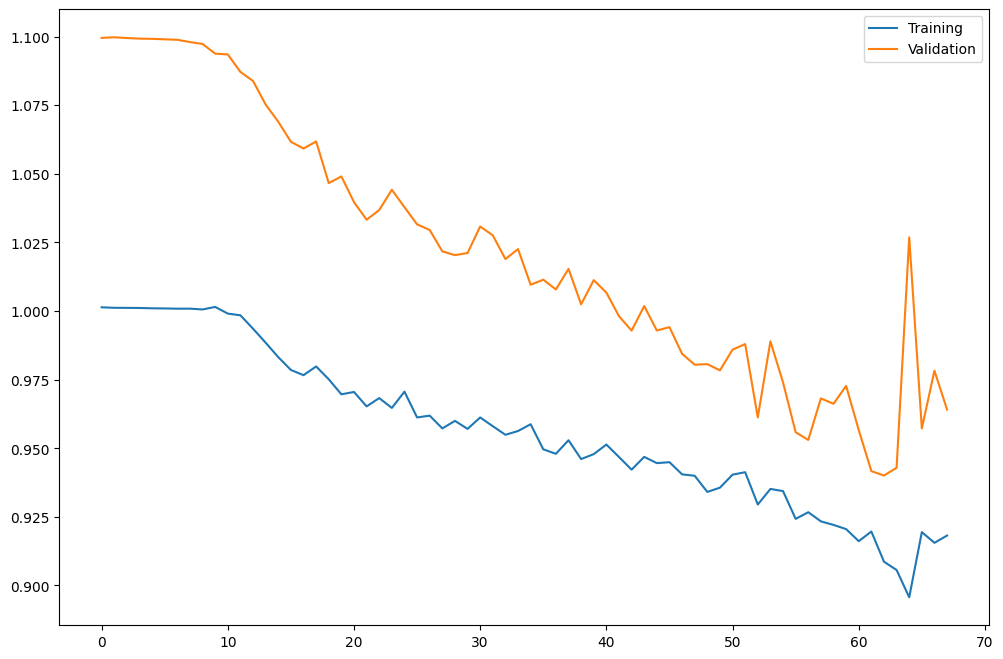

In [54]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

In [ ]:
def LSTM_AE(input_shape):
  inputs = Input(input_shape)
  L1 = LSTM(input_shape[1]//2, activation='relu',return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(input_shape[1]//4, activation='relu',return_sequences=False)(L1)
  L3 = RepeatVector(input_shape[0])(L2)
  L4 = LSTM(input_shape[1]//4, activation='relu',return_sequences=True)(L3) 
  L5 = LSTM(input_shape[1]//2, activation='relu',return_sequences=True)(L4) 
  output = TimeDistributed(Dense(input_shape[1]))(L5)

  model = Model(inputs,output)

  return model


In [ ]:
models = []
scalers = []
clear_session()

for i in range(8):
  print('='*30)
  print(i)

  df = df_list[i]

  scaler = MinMaxScaler()
  scarer_df = scaler.fit_transform(df)
  scalers.append(scaler)
  #scarer_df = scarer_df.reshape(scarer_df.shape[0],1,scarer_df.shape[1])
  print('df shape : ',scarer_df.shape)

  es = EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True, verbose=1, )

  #input_shape = (scarer_df.shape[1],scarer_df.shape[2])

  #model = LSTM_AE(input_shape)
  model = AE(scarer_df.shape[1])

  model.compile(optimizer='adam', loss='mse')

  model.fit(scarer_df, scarer_df, epochs = 100, callbacks = [es], validation_split = 0.3)

  models.append(model)



In [ ]:
for i,m in enumerate(models): 
  #m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_lstm_' + str(i) + '.h5')
  m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_ae_' + str(i) + '.h5')
  
  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/s_lstm_' + str(i) + '.pickle', 'wb') as f:
    pickle.dump(scalers[i], f)


df shape :  (30, 1, 6)
1/1 [==============================] - 0s 73ms/step
Threshold:  0.6787531039758492


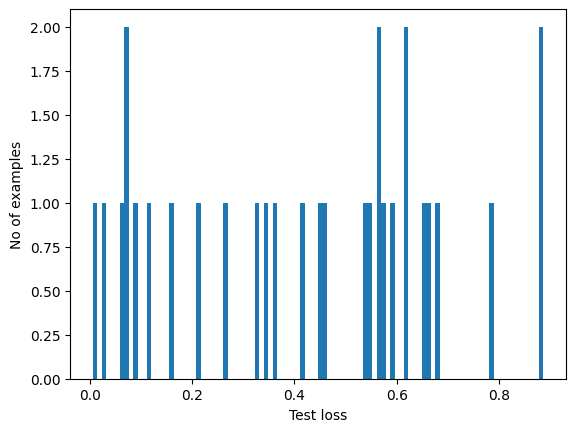

In [ ]:
val_scarer_df = scalers[0].transform(df_val_list[0])
val_scarer_df = val_scarer_df.reshape(val_scarer_df.shape[0],1,val_scarer_df.shape[1])
print('df shape : ',val_scarer_df.shape)

pred = models[0].predict(val_scarer_df)
pred = pred.reshape(pred.shape[0],pred.shape[2])
val_scarer_df = val_scarer_df.reshape(val_scarer_df.shape[0],val_scarer_df.shape[2])

mse = np.mean(np.power(pred - val_scarer_df,2),axis=1)


train_loss = tf.keras.losses.mae(pred, val_scarer_df)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

plt.hist(train_loss, bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()




In [ ]:
pred.shape

(402, 1, 6)

## KFold

In [ ]:
kf = KFold(random_state=2023,shuffle=True)

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df_data)):
  print('='*10)
  print(i)
  print('='*10)
  x_train = df_data.loc[train_index]
  x_test = df_data.loc[test_index]

  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  